# Simple Linear Regression

## Objectives

*   Use scikit-learn to implement simple Linear Regression
*   Create a model, train it, test it and use the model


### Libraries to be imported


In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model

%matplotlib inline

## Reading the data

In [3]:
df = pd.read_csv("FuelConsumptionCo2.csv")

# take a look at the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


 Preparing Data For Linear Regression
 
1. Linear Assumption. 

Linear regression assumes that the relationship between your input and output is linear. It does not support anything else. This may be obvious, but it is good to remember when you have a lot of attributes. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).

2. Remove Noise. 

Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.

3. Remove Collinearity. 

Linear regression will overfit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.

4. Gaussian Distributions. 

Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on your variables to make their distribution more Gaussian looking.


## Data Exploration

Let's first have a descriptive exploration on our data.


In [4]:
# summarize the data
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


<AxesSubplot:>

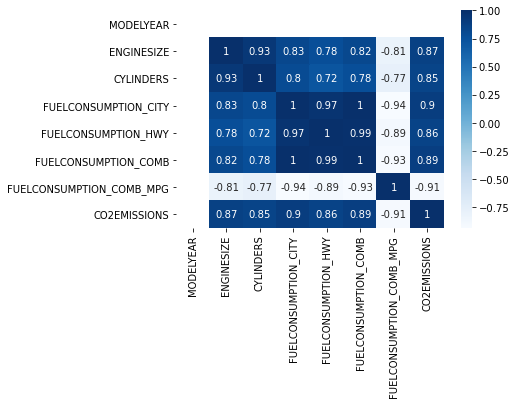

In [42]:
# Getting the Pearson Correlation Coefficient
correlation = df.corr()
sns.heatmap(correlation, cmap="Blues", annot=True)

In [45]:
df.corrwith(df['CO2EMISSIONS']).sort_values()

FUELCONSUMPTION_COMB_MPG   -0.906394
CYLINDERS                   0.849685
FUELCONSUMPTION_HWY         0.861748
ENGINESIZE                  0.874154
FUELCONSUMPTION_COMB        0.892129
FUELCONSUMPTION_CITY        0.898039
CO2EMISSIONS                1.000000
MODELYEAR                        NaN
dtype: float64

Co2 Emissions column is strongly and positively correlated with all the numeric features except FUELCONSUMPTION_COMB_MPG with which it is strongly and negatively correlated.

There is collinearity between FUELCONSUMPTION_HWY,FUELCONSUMPTION_CITY,FUELCONSUMPTION_COMB and FUELCONSUMPTION_COMB_MPG.

Let's select some features to explore more.

In [33]:
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head(10)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244
5,3.5,6,10.0,230
6,3.5,6,10.1,232
7,3.7,6,11.1,255
8,3.7,6,11.6,267
9,2.4,4,9.2,212


Plot frequency distribution of each of these features:


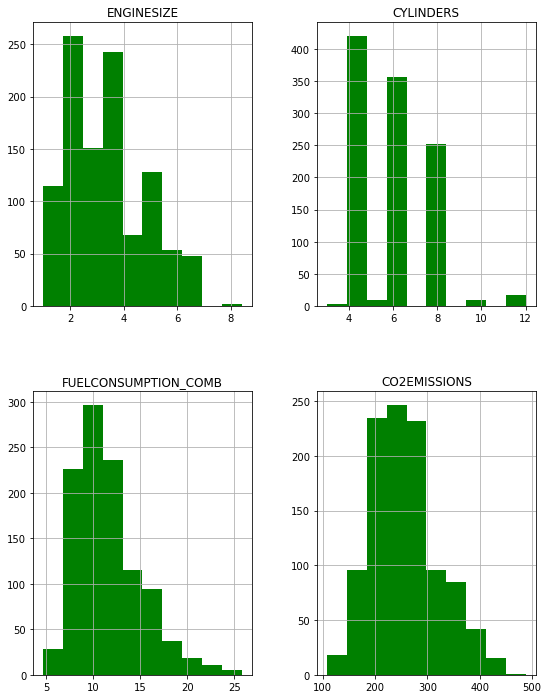

In [46]:
cdf.hist(figsize=(9,12), color='green')
plt.show()

Now, let's plot each of these features against the Emission, to see how linear their relationship is:


#### FUELCONSUMPTION_COMB vs CO2EMISSIONS

Pearson Correlation  Coefficient between FUELCONSUMPTION_COMB and CO2EMISSIONS is : 0.8921285933157569


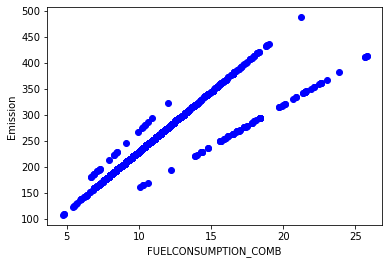

In [60]:
print("Pearson Correlation  Coefficient between FUELCONSUMPTION_COMB and CO2EMISSIONS is : {}".format(correlation.loc['FUELCONSUMPTION_COMB', 'CO2EMISSIONS']))
plt.scatter(cdf.FUELCONSUMPTION_COMB, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("FUELCONSUMPTION_COMB")
plt.ylabel("Emission")
plt.show()

#### ENGINESIZE vs CO2EMISSIONS

Pearson Correlation  Coefficient between ENGINESIZE and CO2EMISSIONS is : 0.8741543683958124


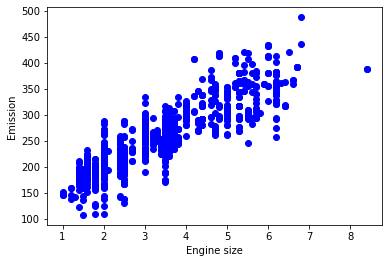

In [62]:
print("Pearson Correlation  Coefficient between ENGINESIZE and CO2EMISSIONS is : {}".format(correlation.loc['ENGINESIZE', 'CO2EMISSIONS']))
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### CYLINDERS vs CO2EMISSIONS

Pearson Correlation  Coefficient between FUELCONSUMPTION_COMB and CO2EMISSIONS is : 0.8496845920141154


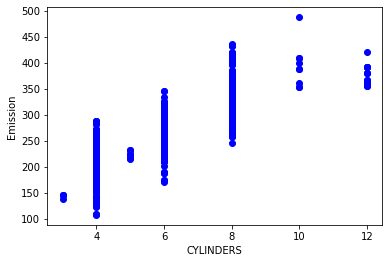

In [106]:
print("Pearson Correlation  Coefficient between FUELCONSUMPTION_COMB and CO2EMISSIONS is : {}".format(correlation.loc['CYLINDERS', 'CO2EMISSIONS']))
plt.scatter(cdf.CYLINDERS, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("CYLINDERS")
plt.ylabel("Emission")
plt.show()

### Creating train and test dataset

Let's split our dataset into train and test sets. 80% of the entire dataset will be used for training and 20% for testing. 

We create a mask to select random rows using **np.random.rand()** function:

In [50]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

### Simple Regression Model

Linear Regression fits a linear model with coefficients B = (B1, ..., Bn) to minimize the 'residual sum of squares' between the actual value y in the dataset, and the predicted value yhat using linear approximation.


#### Train data distribution


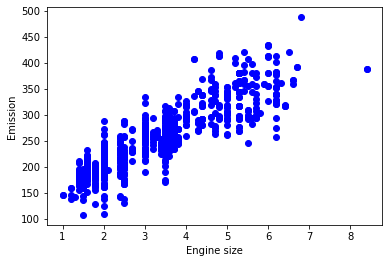

In [51]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

We see that the train data distribution is the same with original data.

#### Modeling

Using sklearn package to model data.

**Coefficient** and **Intercept** in the simple linear regression are the parameters of the fit line.

Sklearn can estimate them directly from our data.

All of the data must be available to traverse and calculate the parameters.

In [107]:
lin_regr = linear_model.LinearRegression()

train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])

lin_regr.fit(train_x, train_y)

# The coefficients
print ('Coefficients: ', lin_regr.coef_[0][0])
print ('Intercept: ',lin_regr.intercept_[0])

Coefficients:  39.006390768720244
Intercept:  125.85582645180986


#### Plot outputs

We can plot the fit line over the data:

Text(0, 0.5, 'Emission')

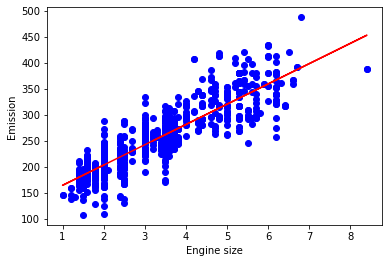

In [86]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.plot(train_x, lin_regr.coef_[0][0]*train_x + lin_regr.intercept_[0], '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")

#### Evaluation

There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set:

Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean Absolute Error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.

*   Root Mean Squared Error (RMSE).

*   R-squared is not an error, but rather a popular metric to measure the performance of the regression model.

It represents how close the data points are to the fitted regression line. 

The higher the R-squared value, the better the model fits your data. 

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).


In [87]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])
test_y_ = lin_regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

Mean absolute error: 25.22
Residual sum of squares (MSE): 1049.82
R2-score: 0.76


Lets see what the evaluation metrics are if we trained a regression model using the `FUELCONSUMPTION_COMB` feature.

Start by selecting `FUELCONSUMPTION_COMB` as the train_x data from the `train` dataframe, then select `FUELCONSUMPTION_COMB` as the test_x data from the `test` dataframe


Mean absolute error: 21.34
Residual sum of squares (MSE): 834.17
R2-score: 0.81


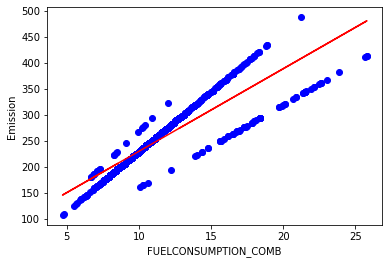

In [108]:
train_x = np.asanyarray(train[['FUELCONSUMPTION_COMB']])
test_x = np.asanyarray(test[['FUELCONSUMPTION_COMB']])

regr = linear_model.LinearRegression()

regr.fit(train_x,train_y)


plt.scatter(train.FUELCONSUMPTION_COMB, train.CO2EMISSIONS,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("FUELCONSUMPTION_COMB")
plt.ylabel("Emission")

test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

Lets see what the evaluation metrics are if we trained a regression model using the `CYLINDERS` feature.

Mean absolute error: 171.87
Residual sum of squares (MSE): 31975.95
R2-score: -6.37


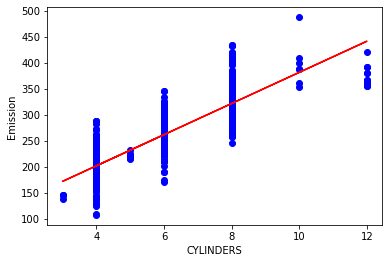

In [109]:
train_x = np.asanyarray(train[['CYLINDERS']])
test_x = np.asanyarray(test[['FUELCONSUMPTION_COMB']])

regr = linear_model.LinearRegression()

regr.fit(train_x,train_y)

plt.scatter(train.CYLINDERS, train.CO2EMISSIONS,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("CYLINDERS")
plt.ylabel("Emission")

test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

We can conclude that FUELCONSUMPTION_COMB is the best predictor using Simple Linear Regression for predicting Co2 Emissions.

Simple Linear Regression Model gave a good accuracy score (R2-score: 0.81) and low MSE and MAE error scores with FUELCONSUMPTION_COMB, comparing the other candidate predictors. Thus it can be used to predict Co2 Emissions.